In [25]:
#check gensim version
import csv
import pandas as pd
import numpy as np
import gensim
print(gensim.__version__)
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

3.8.3


In [8]:
#load all years model for a single language
#change year range for Chinese
model_dic = {}
for i in range(1900, 2010): 
    model_dic['{}'.format(i)] = Word2Vec.load('/share/evansshare/sjia/2012/ita/models/{}.sg'.format(i))

In [29]:
#democracy in every language
lang = 'eng' #change this
democracy_dic = {'eng' : 'democracy',  
                 'ger' : 'demokratie', 
                 'ita' : 'democrazia', 
                 'chi' : '民主', 
                 'rus' : 'демократия', 
                 'fra' : 'démocratie'}
democracy = democracy_dic[lang]

In [78]:
#take word lists
affluence_words = pd.read_csv('/home/fyeh/democracy-main/affluence_pairs.csv') #change this
morality_words = pd.read_csv('/home/fyeh/democracy-main/morality_pairs.csv') #change this
status_words = pd.read_csv('/home/fyeh/democracy-main/status_pairs.csv') #chiange this
rich_words = [x for x in affluence_words['rich_{}'.format(lang)] if pd.isnull(x) == False]
poor_words = [x for x in affluence_words['poor_{}'.format(lang)] if pd.isnull(x) == False]

moral_words = [x for x in morality_words['moral_{}'.format(lang)] if pd.isnull(x) == False]
immoral_words = [x for x in morality_words['immoral_{}'.format(lang)] if pd.isnull(x) == False]

high_words = [x for x in status_words['high_status_{}'.format(lang)] if pd.isnull(x) == False]
low_words = [x for x in status_words['low_status_{}'.format(lang)] if pd.isnull(x) == False]

In [79]:
def normalize(vector):
    '''
    normalize the word vector
    '''
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    '''
    construct a semantic dimension using positive and negative word lists
    '''
    p_vec = []
    n_vec = []
    for p, n in zip(positives, negatives):
        if p in model.wv.vocab and n in model.wv.vocab:
            p_vec.append(normalize(model.wv[p]))
            n_vec.append(normalize(model.wv[n]))
    diff = sum(p_vec) - sum(n_vec)
    return diff

In [90]:
def project_year(model_dic, democracy):
    '''
    construct affluence, morality, and status dimensions, and
    project 'democracy' on these dimensions for each years
    '''
    a = []
    m = []
    s = []
    for year, model in model_dic.items():
        affluence = dimension (v, rich_words, poor_words)
        morality = dimension(v, moral_words, immoral_words)
        status = dimension(v, high_words, low_words)
        a.append(cosine_similarity(model.wv[democracy].reshape(1,-1), affluence.reshape(1,-1))[0][0])
        m.append(cosine_similarity(model.wv[democracy].reshape(1,-1), morality.reshape(1,-1))[0][0])
        s.append(cosine_similarity(model.wv[democracy].reshape(1,-1), status.reshape(1,-1))[0][0])
    projection_df = pd.DataFrame({'affluence' : a, 'morality' : m, 'status' : s},
                                  index = model_dic.keys())
    return projection_df

In [91]:
projection_df = project_year(model_dic, democracy)

In [92]:
#save the file
projection_df.to_csv('projection_{}.csv'.format(lang))

In [60]:
lang_dic = {'eng' : 'English',  
            'ger' : 'Germany', 
            'ita' : 'Italian', 
            'chi' : 'Chinese', 
            'rus' : 'Russian', 
            'fra' : 'France'}

In [94]:
def plot_projection():
    plt.title('Democracy Projection: {}'.format(lang_dic[lang]))
    plt.xlabel('Year')
    plt.ylabel('Projection')
    projection_df['affluence'].plot()
    projection_df['morality'].plot()
    projection_df['status'].plot()
    plt.legend(loc=3);

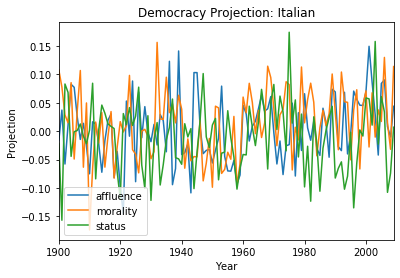

In [95]:
plot_projection()

In [83]:
def plot_10avg_projection():
    plt.title('Democracy Projection: {}'.format(lang_dic[lang]))
    plt.xlabel('Year')
    plt.ylabel('Projection')
    projection_df['affluence_10y_avg'] = projection_df['affluence'].rolling(10).mean().shift(-5)
    projection_df['morality_10y_avg'] = projection_df['morality'].rolling(10).mean().shift(-5)
    projection_df['status_10y_avg'] = projection_df['status'].rolling(10).mean().shift(-5)
    projection_df['affluence_10y_avg'].plot()
    projection_df['morality_10y_avg'].plot()
    projection_df['status_10y_avg'].plot()
    plt.legend(loc=3);

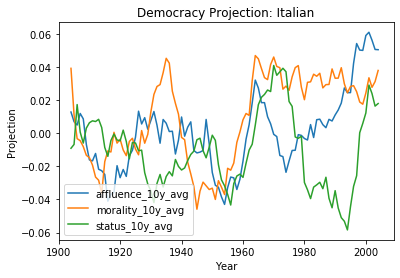

In [96]:
plot_10avg_projection()

In [85]:
projection_df

,affluence,morality,status,affluence_10y_avg,morality_10y_avg,status_10y_avg
1900,-0.016850,0.107766,0.107766,NaN,NaN,NaN
1901,0.037010,0.077598,0.077598,NaN,NaN,NaN
1902,-0.057943,0.028447,0.028447,NaN,NaN,NaN
1903,0.010207,0.014641,0.014641,NaN,NaN,NaN
1904,0.082314,0.085281,0.085281,0.012883,0.039316,0.039316
...,...,...,...,...,...,...
2005,0.083860,0.017012,0.017012,NaN,NaN,NaN
2006,0.090084,0.129698,0.129698,NaN,NaN,NaN
2007,0.007828,0.014989,0.014989,NaN,NaN,NaN
2008,-0.010392,-0.032019,-0.032019,NaN,NaN,NaN
